In [1]:
#DATASETS:  https://www.kaggle.com/competitions/daasbstp2023/data

In [2]:
#Let's start by importing all packages needed.
import sklearn as skl
import pandas as pd
import matplotlib.pyplot as plt
from ipywidgets import interact, widgets
import seaborn as sns
from sklearn import preprocessing
import numpy as np
import time
from dateutil import parser
import pytz

from sklearn.tree import DecisionTreeClassifier, DecisionTreeRegressor
from sklearn.tree import plot_tree, export_text


from sklearn.model_selection import GridSearchCV, RandomizedSearchCV, KFold, train_test_split
from sklearn.pipeline import Pipeline
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import OneHotEncoder, LabelEncoder
from sklearn.compose import make_column_transformer, ColumnTransformer
from sklearn.datasets import make_blobs
from sklearn.decomposition import PCA
from sklearn.linear_model import LinearRegression
from sklearn.cluster import KMeans

from scipy.stats import uniform, poisson

from sklearn.metrics import confusion_matrix, \
                            accuracy_score, \
                            precision_score, \
                            recall_score, \
                            f1_score, \
                            fbeta_score, \
                            mean_squared_error, \
                            mean_absolute_error, \
                            roc_auc_score, \
                            roc_curve, \
                            classification_report


# **Sample and Assess**

In [3]:
#Load the datasets.
df_en1 = pd.read_csv('daasbstp2023/energia_202109-202112.csv', na_filter=False, encoding = "latin")
df_en2 = pd.read_csv('daasbstp2023/energia_202201-202212.csv', na_filter=False, encoding = "latin")
df_me1 = pd.read_csv('daasbstp2023/meteo_202109-202112.csv', na_filter=False, encoding = "latin")
df_me2 = pd.read_csv('daasbstp2023/meteo_202201-202212.csv', na_filter=False, encoding = "latin")

In [4]:
#Append the datasets by type.
df_en = df_en1._append(df_en2,ignore_index=True)
df_me = df_me1._append(df_me2,ignore_index=True)

In [5]:
## TESTING SAMPLING ONLY IN JANUARY TO APRIL
df_en = df_en.iloc[2256:4511]
df_me = df_me.iloc[2256:4511] 

## Energy Consumption Dataset

This dataset provides information on energy consumption recorded at different timestamps. Each record includes the following columns:

- **Data (Date):** The timestamp associated with the record, indicating the date.
- **Hora (Hour):** The hour associated with the record.
- **Normal (kWh):** The amount of electrical energy consumed, in kilowatt-hours (kWh), from the electrical grid during a normal period in daily bi-hourly cycles (non-off-peak hours).
- **Horário Económico (kWh):** The amount of electrical energy consumed, in kilowatt-hours (kWh), from the electrical grid during an economic period in daily bi-hourly cycles (off-peak hours).
- **Autoconsumo (kWh):** The amount of electrical energy consumed, in kilowatt-hours (kWh), generated from solar panels (self-consumption).
- **Injeção na rede (kWh):** A qualitative feature indicating the level of energy injection into the grid on a scale of None, Low, Medium, High, and Very High.

This dataset is utilized in a competition and includes various features, with particular emphasis on the "Injeção na rede (kWh)" feature, which provides information about the qualitative scale of energy injection into the grid.

In [6]:
df_en.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2255 entries, 2256 to 4510
Data columns (total 6 columns):
 #   Column                   Non-Null Count  Dtype  
---  ------                   --------------  -----  
 0   Data                     2255 non-null   object 
 1   Hora                     2255 non-null   int64  
 2   Normal (kWh)             2255 non-null   float64
 3   Horário Económico (kWh)  2255 non-null   float64
 4   Autoconsumo (kWh)        2255 non-null   float64
 5   Injeção na rede (kWh)    2255 non-null   object 
dtypes: float64(3), int64(1), object(2)
memory usage: 105.8+ KB


In [7]:
df_en.iloc[901].to_frame().T

,Data,Hora,Normal (kWh),Horário Económico (kWh),Autoconsumo (kWh),Injeção na rede (kWh)
3157,2022-02-07,13,0.0,0.0,0.258,Very High


In [8]:
df_en.isna().any()

Data                       False
Hora                       False
Normal (kWh)               False
Horário Económico (kWh)    False
Autoconsumo (kWh)          False
Injeção na rede (kWh)      False
dtype: bool

In [9]:
# Unique values for each column in the Energy dataset.
for column in df_en.columns:
    unique_values = df_en[column].unique()
    print(f"{column}, Number of Unique Values: {len(unique_values)}")

Data, Number of Unique Values: 94
Hora, Number of Unique Values: 24
Normal (kWh), Number of Unique Values: 677
Horário Económico (kWh), Number of Unique Values: 491
Autoconsumo (kWh), Number of Unique Values: 450
Injeção na rede (kWh), Number of Unique Values: 5


## Weather Information Dataset

This dataset provides comprehensive information related to weather conditions at different timestamps. The columns in the dataset include:

- **dt (Timestamp):** The timestamp associated with the record.
- **dt_iso (ISO Date):** The date associated with the record, accurate to the second.
- **city_name:** The location for which weather data is recorded.
- **temp (Temperature):** The temperature in degrees Celsius.
- **feels_like (Feels Like):** The perceived temperature in degrees Celsius.
- **temp_min (Min Temperature):** The minimum felt temperature in degrees Celsius.
- **temp_max (Max Temperature):** The maximum felt temperature in degrees Celsius.
- **pressure:** Atmospheric pressure in atmospheres.
- **sea_level:** Atmospheric pressure at sea level in atmospheres.
- **grnd_level:** Atmospheric pressure at local altitude in atmospheres.
- **humidity:** Humidity level as a percentage.
- **wind_speed:** Wind speed in meters per second.
- **rain_1h (Rainfall):** Average precipitation value in the last hour.
- **clouds_all (Cloudiness):** Cloud coverage percentage.
- **weather_description:** Qualitative assessment of weather conditions.


In [10]:
df_me.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2255 entries, 2256 to 4510
Data columns (total 15 columns):
 #   Column               Non-Null Count  Dtype  
---  ------               --------------  -----  
 0   dt                   2255 non-null   int64  
 1   dt_iso               2255 non-null   object 
 2   city_name            2255 non-null   object 
 3   temp                 2255 non-null   float64
 4   feels_like           2255 non-null   float64
 5   temp_min             2255 non-null   float64
 6   temp_max             2255 non-null   float64
 7   pressure             2255 non-null   int64  
 8   sea_level            2255 non-null   object 
 9   grnd_level           2255 non-null   object 
 10  humidity             2255 non-null   int64  
 11  wind_speed           2255 non-null   float64
 12  rain_1h              2255 non-null   object 
 13  clouds_all           2255 non-null   int64  
 14  weather_description  2255 non-null   object 
dtypes: float64(5), int64(4), object(6)


In [11]:
df_me.iloc[801].to_frame().T

,dt,dt_iso,city_name,temp,feels_like,temp_min,temp_max,pressure,sea_level,grnd_level,humidity,wind_speed,rain_1h,clouds_all,weather_description
3057,1641459600,2022-01-06 09:00:00 +0000 UTC,local,8.28,8.28,4.54,8.48,1023,,,86,0.93,,100,overcast clouds


In [12]:
df_me.isna().any()

dt                     False
dt_iso                 False
city_name              False
temp                   False
feels_like             False
temp_min               False
temp_max               False
pressure               False
sea_level              False
grnd_level             False
humidity               False
wind_speed             False
rain_1h                False
clouds_all             False
weather_description    False
dtype: bool

In [13]:
# Unique values for each column in the Energy dataset.
for column in df_me.columns:
    unique_values = df_me[column].unique()
    print(f"{column}, Number of Unique Values: {len(unique_values)}")

dt, Number of Unique Values: 2255
dt_iso, Number of Unique Values: 2255
city_name, Number of Unique Values: 1
temp, Number of Unique Values: 869
feels_like, Number of Unique Values: 1081
temp_min, Number of Unique Values: 201
temp_max, Number of Unique Values: 197
pressure, Number of Unique Values: 35
sea_level, Number of Unique Values: 1
grnd_level, Number of Unique Values: 1
humidity, Number of Unique Values: 78
wind_speed, Number of Unique Values: 527
rain_1h, Number of Unique Values: 137
clouds_all, Number of Unique Values: 101
weather_description, Number of Unique Values: 8


# **Data Processing**

After Loading the data, we must now process it in order to be able to use it in our model. For this we will follow the following steps:
1. Remove unnecessary columns
2. Handle the Date column on both datasets and unify the format
3. Join the datasets
4. Handle the missing values or rows (dates that are not present in both datasets) if any
5. Handle the categorical values

In [14]:
# We can drop city_name, sea_level and grnd_level as they only have one unique value
df_me = df_me.drop(['city_name', 'sea_level', 'grnd_level'], axis=1)

In [15]:
# # Convert columns to categorical
# df_en["Injeção na rede (kWh)"] = df_en["Injeção na rede (kWh)"].astype("category")
# df_me["weather_description"] = df_me['weather_description'].astype("category")

# # For "Injeção na rede (kWh)" column in df_en
# print("Categories for 'Injeção na rede (kWh)' in df_en:")
# print(df_en["Injeção na rede (kWh)"].cat.categories)
# print("\n")

# # For "weather_description" column in df_me
# print("Categories for 'weather_description' in df_me:")
# print(df_me["weather_description"].cat.categories)
# print("\n")


In [16]:
# Convert columns to unified format
df_en['datetime'] = pd.to_datetime(df_en['Data'] + ' ' + df_en['Hora'].astype(str) + ':00:00', format='%Y-%m-%d %H:%M:%S')

# Drop the original 'Data' and 'Hora' columns if needed
df_en = df_en.drop(['Data', 'Hora'], axis=1)

# Print the updated DataFrame
df_en.iloc[901].to_frame().T

,Normal (kWh),Horário Económico (kWh),Autoconsumo (kWh),Injeção na rede (kWh),datetime
3157,0.0,0.0,0.258,Very High,2022-02-07 13:00:00


In [17]:
df_en.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2255 entries, 2256 to 4510
Data columns (total 5 columns):
 #   Column                   Non-Null Count  Dtype         
---  ------                   --------------  -----         
 0   Normal (kWh)             2255 non-null   float64       
 1   Horário Económico (kWh)  2255 non-null   float64       
 2   Autoconsumo (kWh)        2255 non-null   float64       
 3   Injeção na rede (kWh)    2255 non-null   object        
 4   datetime                 2255 non-null   datetime64[ns]
dtypes: datetime64[ns](1), float64(3), object(1)
memory usage: 88.2+ KB


In [18]:
#fix datetime in df_me (loses the UTC tag)
df_me['dt_iso'] = pd.to_datetime(df_me['dt_iso'], format='%Y-%m-%d %H:%M:%S %z UTC')
df_me['dt_iso'] = df_me['dt_iso'].dt.tz_localize(None)
df_me = df_me.rename(columns={"dt_iso": "datetime"})
df_me.iloc[801].to_frame().T

,dt,datetime,temp,feels_like,temp_min,temp_max,pressure,humidity,wind_speed,rain_1h,clouds_all,weather_description
3057,1641459600,2022-01-06 09:00:00,8.28,8.28,4.54,8.48,1023,86,0.93,,100,overcast clouds


In [19]:
# We can also drop the 'dt' column as it is redundant
df_me = df_me.drop(['dt'], axis=1)

In [20]:
# Order the dataframes by datetime so we can detect any time skips
df_en = df_en.sort_values(by=['datetime'])
df_me = df_me.sort_values(by=['datetime'])

In [21]:
time_diff_en = df_en['datetime'].diff()
time_diff_me = df_me['datetime'].diff()

# Print the irregular time intervals
irregularities_en = time_diff_en[time_diff_en != '0 days 01:00:00']
irregularities_me = time_diff_me[time_diff_me != '0 days 01:00:00']
print("Irregular time intervals in df_en:")
print(irregularities_en)
print("\n")
print("Irregular time intervals in df_me:")
print(irregularities_me)


Irregular time intervals in df_en:
2256   NaT
Name: datetime, dtype: timedelta64[ns]


Irregular time intervals in df_me:
2256   NaT
Name: datetime, dtype: timedelta64[ns]


In [22]:
outer_join_merged_df = pd.merge(df_en, df_me, on='datetime', how='outer')

In [23]:
outer_join_merged_df.isna().sum()

Normal (kWh)               672
Horário Económico (kWh)    672
Autoconsumo (kWh)          672
Injeção na rede (kWh)      672
datetime                     0
temp                       672
feels_like                 672
temp_min                   672
temp_max                   672
pressure                   672
humidity                   672
wind_speed                 672
rain_1h                    672
clouds_all                 672
weather_description        672
dtype: int64

Since the datetime data exhibited no irregularities, the additional entries present in the Weather dataset but not in the Energy dataset can be attributed to the Weather dataset containing data from days before or after the Energy dataset's first or last entry, respectively. A manual analysis of the dataset reveals that the Weather dataset includes entries starting from 2021-09-01, while the Energy dataset commences from 2021-09-29. Consequently, it is necessary to exclude entries from the Weather dataset that precede 2021-09-29, as they will not contribute to the modeling process. In order to achieve this we will do an Inner Join between the two datasets on the datetime column, and the resulting dataset will be the one we use going forward.

In [24]:
#at this point, if I do an inner join I am losing 5.7% of all datarows
merged_df = pd.merge(df_en, df_me, on='datetime', how='inner')

In [25]:
#Sava the clean dataset
merged_df.to_csv('merged.csv')

In [26]:
merged_df.rename(columns={'Injeção na rede (kWh)': 'Injection'}, inplace=True)
merged_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1583 entries, 0 to 1582
Data columns (total 15 columns):
 #   Column                   Non-Null Count  Dtype         
---  ------                   --------------  -----         
 0   Normal (kWh)             1583 non-null   float64       
 1   Horário Económico (kWh)  1583 non-null   float64       
 2   Autoconsumo (kWh)        1583 non-null   float64       
 3   Injection                1583 non-null   object        
 4   datetime                 1583 non-null   datetime64[ns]
 5   temp                     1583 non-null   float64       
 6   feels_like               1583 non-null   float64       
 7   temp_min                 1583 non-null   float64       
 8   temp_max                 1583 non-null   float64       
 9   pressure                 1583 non-null   int64         
 10  humidity                 1583 non-null   int64         
 11  wind_speed               1583 non-null   float64       
 12  rain_1h                  1583 non-

In [27]:
merged_df.iloc[901].to_frame().T

,Normal (kWh),Horário Económico (kWh),Autoconsumo (kWh),Injection,datetime,temp,feels_like,temp_min,temp_max,pressure,humidity,wind_speed,rain_1h,clouds_all,weather_description
901,0.0,0.0,0.258,Very High,2022-02-07 13:00:00,18.48,17.3,17.89,18.72,1030,35,1.76,,3,sky is clear


In [28]:
# Convert 'rain_1h' column to float and replace empty strings with 0
merged_df['rain_1h'] = pd.to_numeric(merged_df['rain_1h'].replace('', '0'))

In [29]:
merged_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1583 entries, 0 to 1582
Data columns (total 15 columns):
 #   Column                   Non-Null Count  Dtype         
---  ------                   --------------  -----         
 0   Normal (kWh)             1583 non-null   float64       
 1   Horário Económico (kWh)  1583 non-null   float64       
 2   Autoconsumo (kWh)        1583 non-null   float64       
 3   Injection                1583 non-null   object        
 4   datetime                 1583 non-null   datetime64[ns]
 5   temp                     1583 non-null   float64       
 6   feels_like               1583 non-null   float64       
 7   temp_min                 1583 non-null   float64       
 8   temp_max                 1583 non-null   float64       
 9   pressure                 1583 non-null   int64         
 10  humidity                 1583 non-null   int64         
 11  wind_speed               1583 non-null   float64       
 12  rain_1h                  1583 non-

In [30]:
weather_description_counts = merged_df['weather_description'].value_counts()
print(weather_description_counts)

weather_description
sky is clear        616
overcast clouds     453
broken clouds       160
scattered clouds    121
light rain          109
few clouds          106
moderate rain        18
Name: count, dtype: int64


In [31]:
# Perform One-Hot Encoding for 'weather_description'
merged_df = pd.get_dummies(merged_df, columns=['weather_description'], prefix='weather')


In [32]:
merged_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1583 entries, 0 to 1582
Data columns (total 21 columns):
 #   Column                    Non-Null Count  Dtype         
---  ------                    --------------  -----         
 0   Normal (kWh)              1583 non-null   float64       
 1   Horário Económico (kWh)   1583 non-null   float64       
 2   Autoconsumo (kWh)         1583 non-null   float64       
 3   Injection                 1583 non-null   object        
 4   datetime                  1583 non-null   datetime64[ns]
 5   temp                      1583 non-null   float64       
 6   feels_like                1583 non-null   float64       
 7   temp_min                  1583 non-null   float64       
 8   temp_max                  1583 non-null   float64       
 9   pressure                  1583 non-null   int64         
 10  humidity                  1583 non-null   int64         
 11  wind_speed                1583 non-null   float64       
 12  rain_1h             

In [33]:
# sns.pairplot(merged_df[['Normal (kWh)', 'Horário Económico (kWh)', 'Autoconsumo (kWh)', 'temp', 'rain_1h', 'humidity']])
# plt.show()

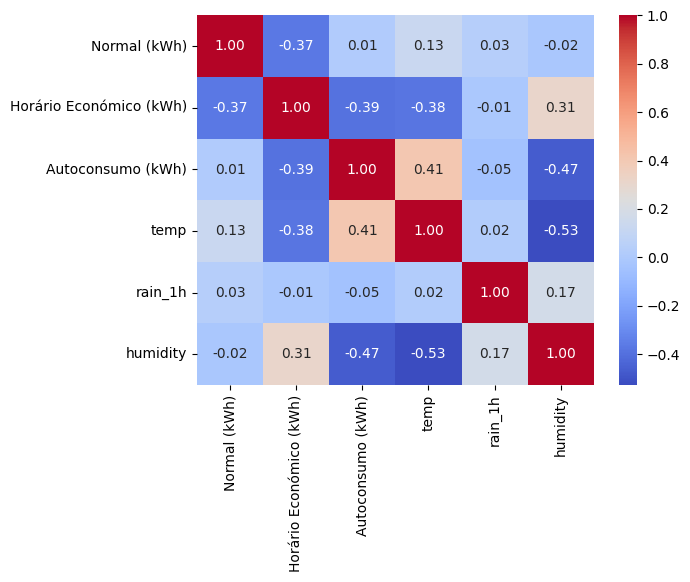

In [34]:
corr_matrix = merged_df[['Normal (kWh)', 'Horário Económico (kWh)', 'Autoconsumo (kWh)', 'temp', 'rain_1h', 'humidity']].corr()
sns.heatmap(corr_matrix, annot=True, cmap='coolwarm', fmt=".2f")
plt.show()

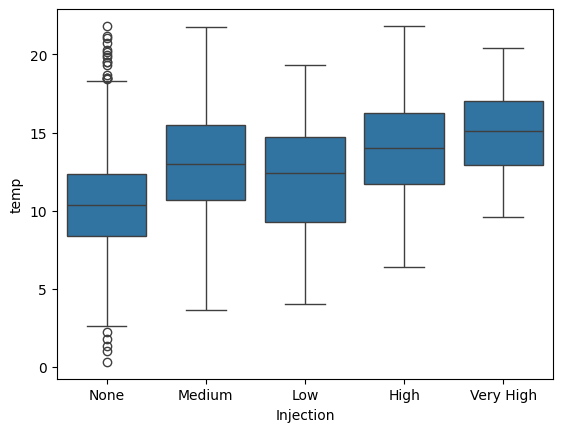

In [35]:
sns.boxplot(x='Injection', y='temp', data=merged_df)
plt.show()


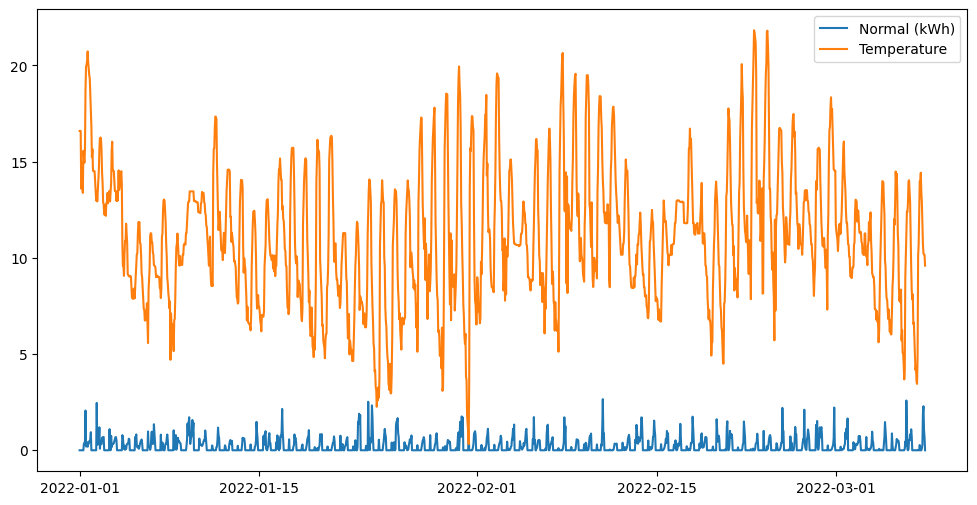

In [36]:
plt.figure(figsize=(12, 6))
plt.plot(merged_df['datetime'], merged_df['Normal (kWh)'], label='Normal (kWh)')
plt.plot(merged_df['datetime'], merged_df['temp'], label='Temperature')
plt.legend()
plt.show()

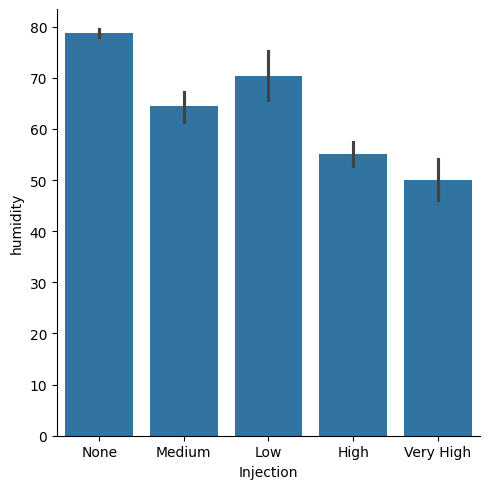

In [37]:
sns.catplot(x='Injection', y='humidity', kind='bar', data=merged_df)
plt.show()

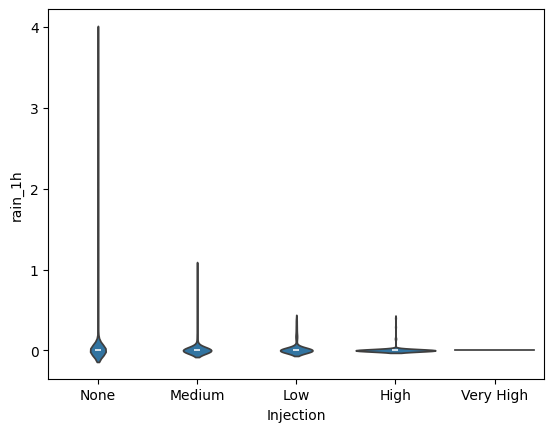

In [38]:
sns.violinplot(x='Injection', y='rain_1h', data=merged_df)
plt.show()

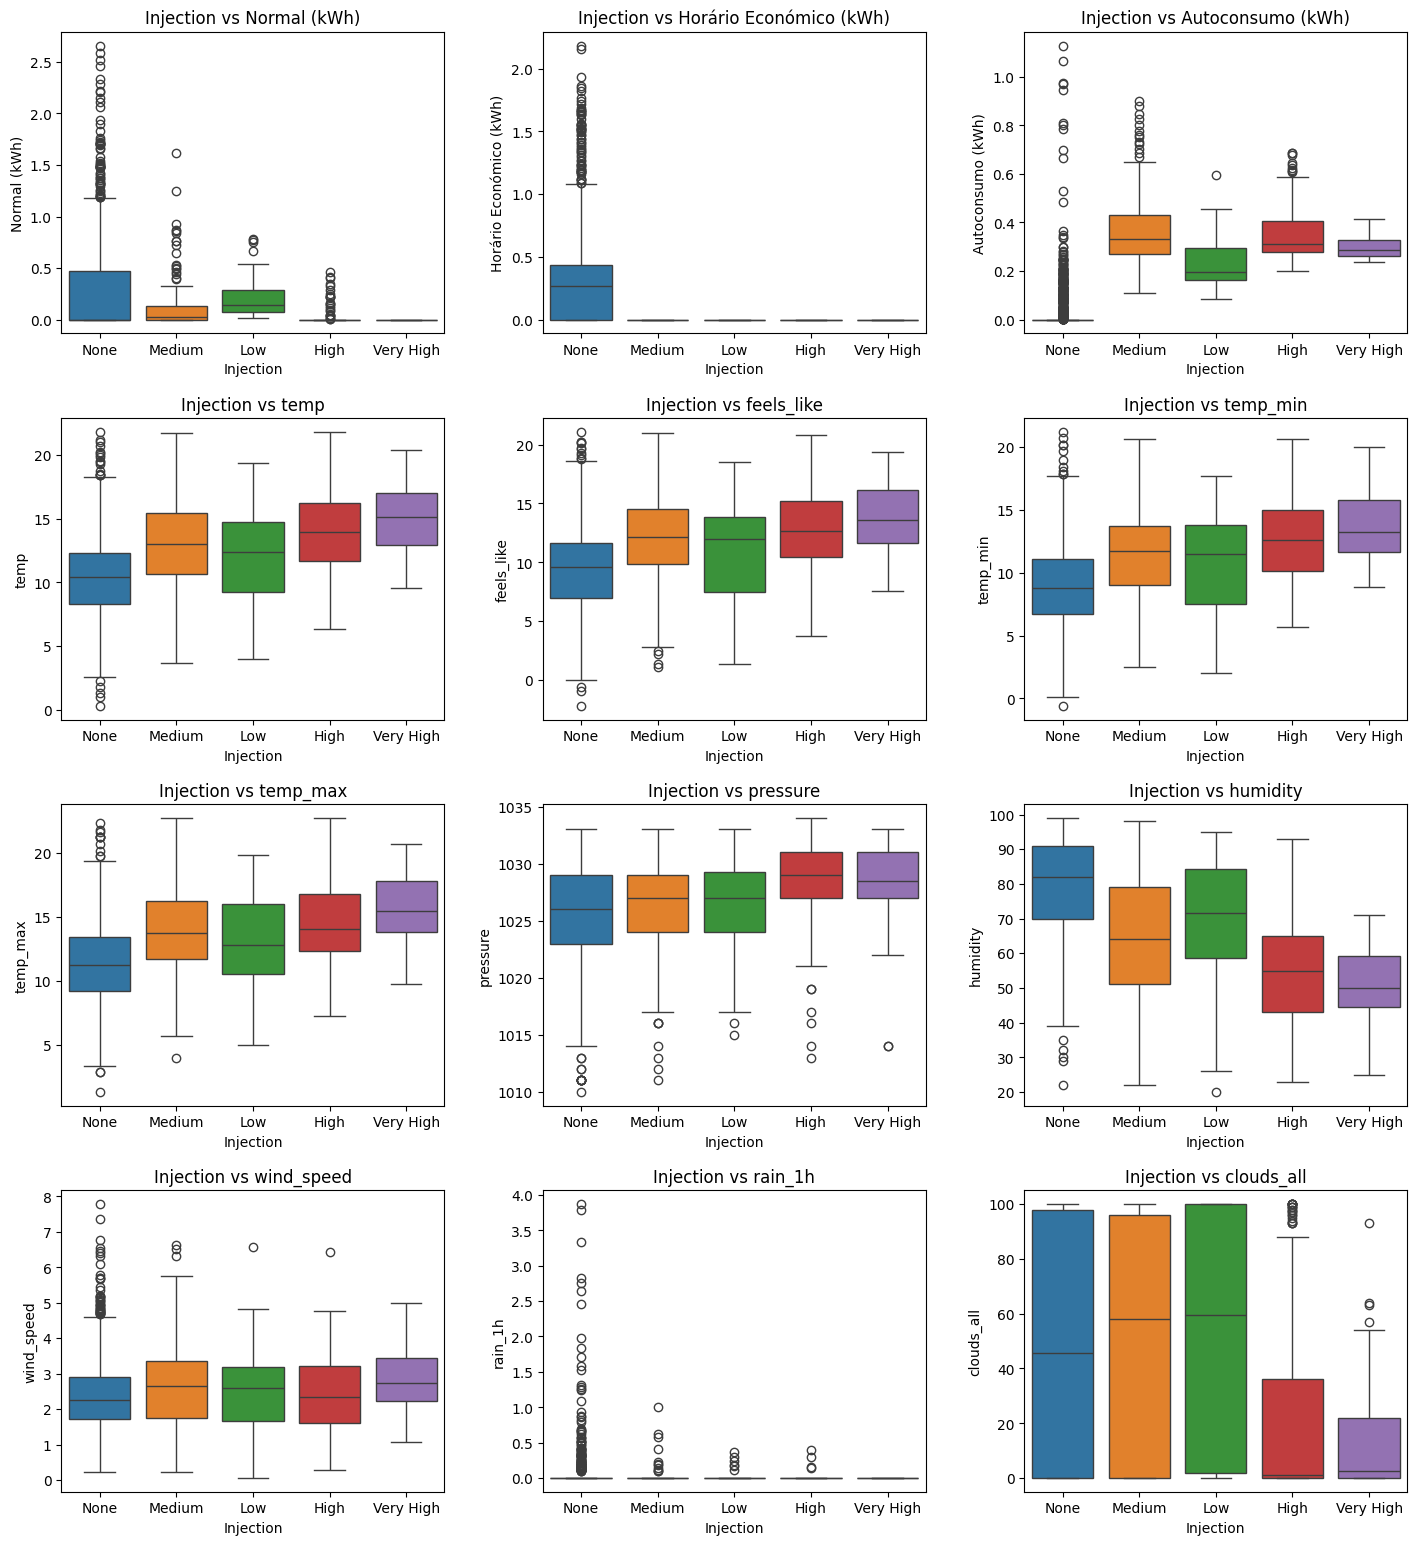

In [39]:
# Specify the columns you want to visualize
columns_to_visualize = ['Normal (kWh)', 'Horário Económico (kWh)', 'Autoconsumo (kWh)', 'temp', 'feels_like',
                         'temp_min', 'temp_max', 'pressure', 'humidity', 'wind_speed', 'rain_1h', 'clouds_all']

# Set up subplots with multiple columns
num_columns = 3  # You can adjust the number of columns as per your preference
num_rows = -(-len(columns_to_visualize) // num_columns)  # Ceiling division to determine the number of rows

fig, axes = plt.subplots(nrows=num_rows, ncols=num_columns, figsize=(15, 4 * num_rows))
fig.tight_layout(pad=4.0)

# Flatten the axes array to simplify indexing
axes = axes.flatten()

# Create individual plots for each column
for i, column in enumerate(columns_to_visualize):
    ax = axes[i]
    sns.boxplot(x='Injection', y=column, data=merged_df, ax=ax, hue='Injection')
    ax.set_title(f'Injection vs {column}')
    ax.set_xlabel('Injection')
    ax.set_ylabel(column)

# Remove empty subplots if needed
for i in range(len(columns_to_visualize), len(axes)):
    fig.delaxes(axes[i])

plt.show()

The problem is a classification problem with ordinal labels. We have the following possible values for the target variable: None, Low, Medium, High, Very High. Here are some suitable models for ordinal classification:

1. **Ordinal Logistic Regression:**
   - **Type:** Supervised learning, ordinal classification.
   - **Strengths:** Designed specifically for ordinal outcomes, interpretable, and extends logistic regression to handle ordered categories.
   - **Considerations:** Assumes the proportional odds assumption.

2. **Random Forest Classifier for Ordinal Regression:**
   - **Type:** Supervised learning, classification.
   - **Strengths:** Handles non-linearity and interactions, robust to overfitting, and can handle ordinal targets by using the `OrdinalClassifier` from scikit-learn.
   - **Considerations:** Might not be as interpretable as ordinal logistic regression.

3. **Support Vector Machines (SVM) for Ordinal Classification:**
   - **Type:** Supervised learning, ordinal classification.
   - **Strengths:** Effective in high-dimensional spaces, versatile, and can be adapted for ordinal targets.
   - **Considerations:** Sensitive to the choice of kernel function and parameters.

4. **Ordinal Neural Networks:**
   - **Type:** Deep learning, ordinal classification.
   - **Strengths:** Can capture complex relationships, automatically learns feature representations, and can be adapted for ordinal outcomes.
   - **Considerations:** Requires more data, computationally intensive, and might be overkill for simpler problems.


# Preparing Test Dataset
---

In [40]:
test_en = pd.read_csv('daasbstp2023/energia_202301-202304.csv', na_filter=False, encoding = "latin")
test_me = pd.read_csv('daasbstp2023/meteo_202301-202304.csv', na_filter=False, encoding = "latin")

In [41]:
test_en.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2256 entries, 0 to 2255
Data columns (total 5 columns):
 #   Column                   Non-Null Count  Dtype  
---  ------                   --------------  -----  
 0   Data                     2256 non-null   object 
 1   Hora                     2256 non-null   int64  
 2   Normal (kWh)             2256 non-null   float64
 3   Horário Económico (kWh)  2256 non-null   float64
 4   Autoconsumo (kWh)        2256 non-null   float64
dtypes: float64(3), int64(1), object(1)
memory usage: 88.2+ KB


In [42]:
test_me.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1752 entries, 0 to 1751
Data columns (total 15 columns):
 #   Column               Non-Null Count  Dtype  
---  ------               --------------  -----  
 0   dt                   1752 non-null   int64  
 1   dt_iso               1752 non-null   object 
 2   city_name            1752 non-null   object 
 3   temp                 1752 non-null   float64
 4   feels_like           1752 non-null   float64
 5   temp_min             1752 non-null   float64
 6   temp_max             1752 non-null   float64
 7   pressure             1752 non-null   int64  
 8   sea_level            1752 non-null   object 
 9   grnd_level           1752 non-null   object 
 10  humidity             1752 non-null   int64  
 11  wind_speed           1752 non-null   float64
 12  rain_1h              1752 non-null   object 
 13  clouds_all           1752 non-null   int64  
 14  weather_description  1752 non-null   object 
dtypes: float64(5), int64(4), object(6)
mem

In [43]:
test_me.isna().any()

dt                     False
dt_iso                 False
city_name              False
temp                   False
feels_like             False
temp_min               False
temp_max               False
pressure               False
sea_level              False
grnd_level             False
humidity               False
wind_speed             False
rain_1h                False
clouds_all             False
weather_description    False
dtype: bool

In [44]:
test_en.isna().any()

Data                       False
Hora                       False
Normal (kWh)               False
Horário Económico (kWh)    False
Autoconsumo (kWh)          False
dtype: bool

In [45]:
# Unique values for each column in the Energy dataset.
for column in test_en.columns:
    unique_values = test_en[column].unique()
    print(f"{column}, Number of Unique Values: {len(unique_values)}")

Data, Number of Unique Values: 94
Hora, Number of Unique Values: 24
Normal (kWh), Number of Unique Values: 709
Horário Económico (kWh), Number of Unique Values: 490
Autoconsumo (kWh), Number of Unique Values: 485


In [46]:
# Unique values for each column in the Meteorology dataset

for column in test_me.columns:
    unique_values = test_me[column].unique()
    print(f"{column}, Number of Unique Values: {len(unique_values)}")

dt, Number of Unique Values: 1752
dt_iso, Number of Unique Values: 1752
city_name, Number of Unique Values: 1
temp, Number of Unique Values: 889
feels_like, Number of Unique Values: 1007
temp_min, Number of Unique Values: 169
temp_max, Number of Unique Values: 174
pressure, Number of Unique Values: 31
sea_level, Number of Unique Values: 1
grnd_level, Number of Unique Values: 1
humidity, Number of Unique Values: 71
wind_speed, Number of Unique Values: 512
rain_1h, Number of Unique Values: 121
clouds_all, Number of Unique Values: 99
weather_description, Number of Unique Values: 8


In [47]:
test_me = test_me.drop(['city_name', 'sea_level', 'grnd_level'], axis=1)

In [48]:
# Convert columns to unified format
test_en['datetime'] = pd.to_datetime(test_en['Data'] + ' ' + test_en['Hora'].astype(str) + ':00:00', format='%Y-%m-%d %H:%M:%S')

# Drop the original 'Data' and 'Hora' columns if needed
test_en = test_en.drop(['Data', 'Hora'], axis=1)

# Print the updated DataFrame
test_en.iloc[901].to_frame().T

,Normal (kWh),Horário Económico (kWh),Autoconsumo (kWh),datetime
901,0.0,0.0,0.311,2023-02-07 13:00:00


In [49]:
# Fix datetime in test_me (loses the UTC tag)
test_me['dt_iso'] = pd.to_datetime(test_me['dt_iso'], format='%Y-%m-%d %H:%M:%S %z UTC')
test_me['dt_iso'] = test_me['dt_iso'].dt.tz_localize(None)
test_me = test_me.rename(columns={"dt_iso": "datetime"})
test_me.iloc[801].to_frame().T

,dt,datetime,temp,feels_like,temp_min,temp_max,pressure,humidity,wind_speed,rain_1h,clouds_all,weather_description
801,1675414800,2023-02-03 09:00:00,7.1,4.92,4.71,8.34,1033,81,3.16,,0,sky is clear


In [50]:
# We can also drop the 'dt' column as it is redundant
test_me = test_me.drop(['dt'], axis=1)

In [51]:
# Order the dataframes by datetime so we can detect any time skips
test_en = test_en.sort_values(by=['datetime'])
test_me = test_me.sort_values(by=['datetime'])

In [52]:
time_diff_en = df_en['datetime'].diff()
time_diff_me = df_me['datetime'].diff()

# Print the irregular time intervals
irregularities_en = time_diff_en[time_diff_en != '0 days 01:00:00']
irregularities_me = time_diff_me[time_diff_me != '0 days 01:00:00']
print("Irregular time intervals in df_en:")
print(irregularities_en)
print("\n")
print("Irregular time intervals in df_me:")
print(irregularities_me)

Irregular time intervals in df_en:
2256   NaT
Name: datetime, dtype: timedelta64[ns]


Irregular time intervals in df_me:
2256   NaT
Name: datetime, dtype: timedelta64[ns]


In [53]:
outer_join_test_df = pd.merge(test_en, test_me, on='datetime', how='outer')

In [54]:
outer_join_test_df.isna().sum()

Normal (kWh)                 0
Horário Económico (kWh)      0
Autoconsumo (kWh)            0
datetime                     0
temp                       504
feels_like                 504
temp_min                   504
temp_max                   504
pressure                   504
humidity                   504
wind_speed                 504
rain_1h                    504
clouds_all                 504
weather_description        504
dtype: int64

In [55]:
outer_join_test_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2256 entries, 0 to 2255
Data columns (total 14 columns):
 #   Column                   Non-Null Count  Dtype         
---  ------                   --------------  -----         
 0   Normal (kWh)             2256 non-null   float64       
 1   Horário Económico (kWh)  2256 non-null   float64       
 2   Autoconsumo (kWh)        2256 non-null   float64       
 3   datetime                 2256 non-null   datetime64[ns]
 4   temp                     1752 non-null   float64       
 5   feels_like               1752 non-null   float64       
 6   temp_min                 1752 non-null   float64       
 7   temp_max                 1752 non-null   float64       
 8   pressure                 1752 non-null   float64       
 9   humidity                 1752 non-null   float64       
 10  wind_speed               1752 non-null   float64       
 11  rain_1h                  1752 non-null   object        
 12  clouds_all               1752 non-

In [56]:
test_merged = outer_join_test_df

test_merged['rain_1h'] = pd.to_numeric(test_merged['rain_1h'].replace('', '0'))

In [57]:
test_merged.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2256 entries, 0 to 2255
Data columns (total 14 columns):
 #   Column                   Non-Null Count  Dtype         
---  ------                   --------------  -----         
 0   Normal (kWh)             2256 non-null   float64       
 1   Horário Económico (kWh)  2256 non-null   float64       
 2   Autoconsumo (kWh)        2256 non-null   float64       
 3   datetime                 2256 non-null   datetime64[ns]
 4   temp                     1752 non-null   float64       
 5   feels_like               1752 non-null   float64       
 6   temp_min                 1752 non-null   float64       
 7   temp_max                 1752 non-null   float64       
 8   pressure                 1752 non-null   float64       
 9   humidity                 1752 non-null   float64       
 10  wind_speed               1752 non-null   float64       
 11  rain_1h                  1752 non-null   float64       
 12  clouds_all               1752 non-

In [58]:
# Perform One-Hot Encoding for 'weather_description'
test_merged = pd.get_dummies(test_merged, columns=['weather_description'], prefix='weather')

In [59]:
test_merged.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2256 entries, 0 to 2255
Data columns (total 21 columns):
 #   Column                        Non-Null Count  Dtype         
---  ------                        --------------  -----         
 0   Normal (kWh)                  2256 non-null   float64       
 1   Horário Económico (kWh)       2256 non-null   float64       
 2   Autoconsumo (kWh)             2256 non-null   float64       
 3   datetime                      2256 non-null   datetime64[ns]
 4   temp                          1752 non-null   float64       
 5   feels_like                    1752 non-null   float64       
 6   temp_min                      1752 non-null   float64       
 7   temp_max                      1752 non-null   float64       
 8   pressure                      1752 non-null   float64       
 9   humidity                      1752 non-null   float64       
 10  wind_speed                    1752 non-null   float64       
 11  rain_1h                       

In [60]:
# Assuming merged_df['datetime'] and test_merged['datetime'] are in datetime format
test_merged_filled = test_merged.copy()

# Iterate over rows in test_merged
for index, row in test_merged.iterrows():
    if pd.isna(row['temp']):
        # Find the corresponding row in merged_df for the same hour on previous days
        matching_rows = merged_df[
            (merged_df['datetime'].dt.hour == row['datetime'].hour) &
            (merged_df['datetime'] < row['datetime'])
        ]

        # Check if matching_rows is not empty
        if not matching_rows.empty:
            # Use the values from the last available row
            matching_row = matching_rows.iloc[-1]

            # Update the missing values in test_merged with values from merged_df
            test_merged_filled.loc[index, ['temp', 'feels_like', 'temp_min', 'temp_max', 'pressure', 'humidity', 'wind_speed', 'rain_1h', 'clouds_all']] = matching_row[['temp', 'feels_like', 'temp_min', 'temp_max', 'pressure', 'humidity', 'wind_speed', 'rain_1h', 'clouds_all']]

# Now, test_merged_filled should have missing values filled with corresponding values from merged_df
test_merged_filled.info()

test_merged_filled.iloc[2200].to_frame().T

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2256 entries, 0 to 2255
Data columns (total 21 columns):
 #   Column                        Non-Null Count  Dtype         
---  ------                        --------------  -----         
 0   Normal (kWh)                  2256 non-null   float64       
 1   Horário Económico (kWh)       2256 non-null   float64       
 2   Autoconsumo (kWh)             2256 non-null   float64       
 3   datetime                      2256 non-null   datetime64[ns]
 4   temp                          2256 non-null   float64       
 5   feels_like                    2256 non-null   float64       
 6   temp_min                      2256 non-null   float64       
 7   temp_max                      2256 non-null   float64       
 8   pressure                      2256 non-null   float64       
 9   humidity                      2256 non-null   float64       
 10  wind_speed                    2256 non-null   float64       
 11  rain_1h                       

,Normal (kWh),Horário Económico (kWh),Autoconsumo (kWh),datetime,temp,feels_like,temp_min,temp_max,pressure,humidity,...,rain_1h,clouds_all,weather_broken clouds,weather_few clouds,weather_heavy intensity rain,weather_light rain,weather_moderate rain,weather_overcast clouds,weather_scattered clouds,weather_sky is clear
2200,0.015,0.0,0.465,2023-04-02 16:00:00,12.88,11.48,11.12,13.99,1011.0,48.0,...,0.0,98.0,False,False,False,False,False,False,False,False


In [61]:
# Count the number of each unique value in merged_df['Injection']
injection_counts = merged_df['Injection'].value_counts()
print(injection_counts)

Injection
None         1176
High          161
Medium        158
Low            56
Very High      32
Name: count, dtype: int64


# **MODEL TRAINING**
---

In [62]:
# Convert datetime features in training dataset
merged_df['year'] = merged_df['datetime'].dt.year
merged_df['month'] = merged_df['datetime'].dt.month
merged_df['day'] = merged_df['datetime'].dt.day
merged_df['hour'] = merged_df['datetime'].dt.hour

# Drop the original datetime column
merged_df = merged_df.drop('datetime', axis=1)

# Convert datetime features in test dataset
test_merged_filled['year'] = test_merged_filled['datetime'].dt.year
test_merged_filled['month'] = test_merged_filled['datetime'].dt.month
test_merged_filled['day'] = test_merged_filled['datetime'].dt.day
test_merged_filled['hour'] = test_merged_filled['datetime'].dt.hour

# Drop the original datetime column
test_merged_filled = test_merged_filled.drop('datetime', axis=1)



# List of columns to drop
columns_to_drop = ['weather_broken clouds', 'weather_few clouds', 
                    'weather_light rain', 'weather_moderate rain', 
                    'weather_overcast clouds', 'weather_scattered clouds', 
                    'weather_sky is clear', 'year']


merged_df = merged_df.drop(columns_to_drop, axis=1)
test_merged_filled = test_merged_filled.drop(columns_to_drop, axis=1)



# First Model: Random Forest Classifier

In [63]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score
from sklearn.model_selection import GridSearchCV

# Assuming 'Injection' is the target variable
X = merged_df.drop(['Injection'], axis=1)
y = merged_df['Injection']

# Split the data into training and validation sets
X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.2, random_state=232)


# Create a Random Forest model
rf_model = RandomForestClassifier(random_state=44253)

# Define the parameter grid for GridSearch
param_grid = {
    'n_estimators': [50, 100, 150],  # You can adjust the range of values
    'max_depth': [None, 10, 20],      # You can adjust the range of values
    'min_samples_split': [2, 5, 10],  # You can adjust the range of values
    'min_samples_leaf': [1, 2, 4]      # You can adjust the range of values
}

# Perform GridSearch with 5-fold cross-validation
grid_search = GridSearchCV(estimator=rf_model, param_grid=param_grid, cv=5, scoring='accuracy', n_jobs=-1)
grid_search.fit(X_train, y_train)

# Print the best hyperparameters found by GridSearch
print("Best Hyperparameters:", grid_search.best_params_)

# Make predictions on the validation set using the best model
best_model = grid_search.best_estimator_
val_predictions = best_model.predict(X_val)

# Evaluate the best model
val_accuracy = accuracy_score(y_val, val_predictions)
print(f'Validation Accuracy with Best Model: {val_accuracy}')


Best Hyperparameters: {'max_depth': None, 'min_samples_leaf': 1, 'min_samples_split': 2, 'n_estimators': 100}
Validation Accuracy with Best Model: 0.8769716088328076


## Alternative Grid Search

In [64]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score
from sklearn.model_selection import GridSearchCV

# Assuming 'Injection' is the target variable
X = merged_df.drop(['Injection'], axis=1)
y = merged_df['Injection']

# Split the data into training and validation sets
X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.2, random_state=232)


# Create a Random Forest model
rf_model = RandomForestClassifier(random_state=4253, max_depth=None, min_samples_leaf=1)

# Define the parameter grid for GridSearch
param_grid = {
    'n_estimators': [250, 300, 200],  # You can adjust the range of values
    'min_samples_split': [4, 5, 6],  # You can adjust the range of values
}

# Perform GridSearch with 5-fold cross-validation
grid_search = GridSearchCV(estimator=rf_model, param_grid=param_grid, cv=5, scoring='accuracy', n_jobs=-1)
grid_search.fit(X_train, y_train)

# Print the best hyperparameters found by GridSearch
print("Best Hyperparameters:", grid_search.best_params_)

# Make predictions on the validation set using the best model
best_model = grid_search.best_estimator_
val_predictions = best_model.predict(X_val)

# Evaluate the best model
val_accuracy = accuracy_score(y_val, val_predictions)
print(f'Validation Accuracy with Best Model: {val_accuracy}')


Best Hyperparameters: {'min_samples_split': 4, 'n_estimators': 200}
Validation Accuracy with Best Model: 0.8801261829652997


### Using the hyperparameters obtained from the RandomizedSearchCV

In [65]:
from sklearn.ensemble import RandomForestClassifier

# Best hyperparameters from GridSearchCV
best_params = {'max_depth': None, 'min_samples_leaf': 1, 'min_samples_split': 4, 'n_estimators': 250}

# Create a Random Forest model with the best hyperparameters
best_model = RandomForestClassifier(
    random_state=4253,
    n_estimators=best_params['n_estimators'],
    max_depth=best_params['max_depth'],
    min_samples_split=best_params['min_samples_split'],
    min_samples_leaf=best_params['min_samples_leaf']
)

# Fit the model on the entire training data
best_model.fit(X_train, y_train)

# Make predictions on the validation set
val_predictions = best_model.predict(X_val)

# Evaluate the model
val_accuracy = accuracy_score(y_val, val_predictions)
print(f'Validation Accuracy with Best Model: {val_accuracy}')

Validation Accuracy with Best Model: 0.8738170347003155


## gridsearch but with class_weight='balanced'

In [66]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score
from sklearn.model_selection import GridSearchCV

# Assuming 'Injection' is the target variable
X = merged_df.drop(['Injection'], axis=1)
y = merged_df['Injection']

# Split the data into training and validation sets
X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.2, random_state=232)


# Create a Random Forest model
rf_model = RandomForestClassifier(random_state=4353, class_weight='balanced')

# Define the parameter grid for GridSearch
param_grid = {
    'n_estimators': [50, 100, 150],  # You can adjust the range of values
    'max_depth': [None, 10, 20],      # You can adjust the range of values
    'min_samples_split': [2, 5, 10],  # You can adjust the range of values
    'min_samples_leaf': [1, 2, 4]      # You can adjust the range of values
}

# Perform GridSearch with 5-fold cross-validation
grid_search = GridSearchCV(estimator=rf_model, param_grid=param_grid, cv=5, scoring='accuracy', n_jobs=-1)
grid_search.fit(X_train, y_train)

# Print the best hyperparameters found by GridSearch
print("Best Hyperparameters:", grid_search.best_params_)

# Make predictions on the validation set using the best model
best_model = grid_search.best_estimator_
val_predictions = best_model.predict(X_val)

# Evaluate the best model
val_accuracy = accuracy_score(y_val, val_predictions)
print(f'Validation Accuracy with Best Model: {val_accuracy}')


Best Hyperparameters: {'max_depth': None, 'min_samples_leaf': 1, 'min_samples_split': 2, 'n_estimators': 150}
Validation Accuracy with Best Model: 0.889589905362776


## Using the parameters from the seach with class weight

Validation Accuracy with Best Model: 0.889589905362776


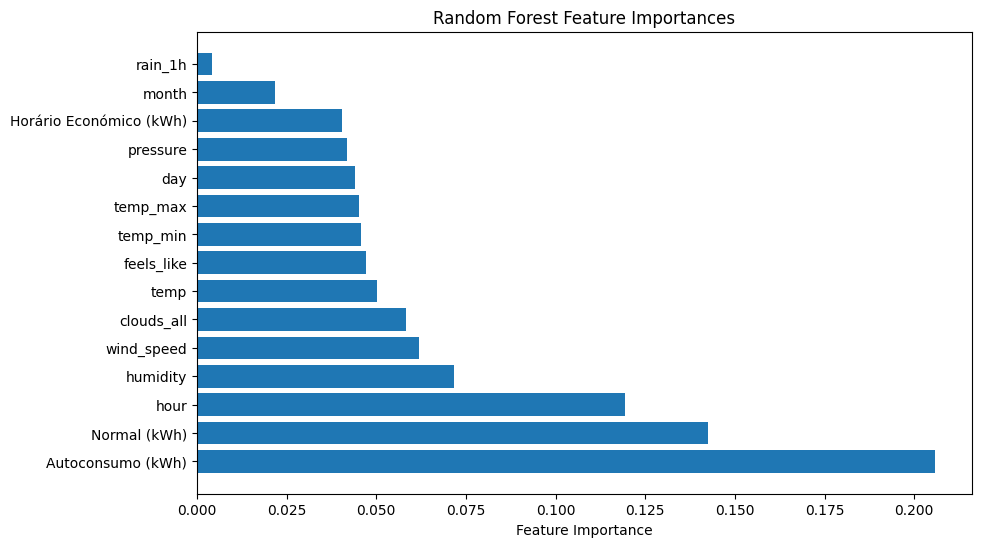

In [67]:
from sklearn.ensemble import RandomForestClassifier

# Best hyperparameters from GridSearchCV
best_params = {'max_depth': 20, 'min_samples_leaf': 1, 'min_samples_split': 2, 'n_estimators': 150}

# Create a Random Forest model with the best hyperparameters
best_model = RandomForestClassifier(
    random_state=4353,
    n_estimators=best_params['n_estimators'],
    max_depth=best_params['max_depth'],
    min_samples_split=best_params['min_samples_split'],
    min_samples_leaf=best_params['min_samples_leaf'],
    class_weight='balanced'
)

# Fit the model on the entire training data
best_model.fit(X_train, y_train)

# Make predictions on the validation set
val_predictions = best_model.predict(X_val)

# Evaluate the model
val_accuracy = accuracy_score(y_val, val_predictions)
print(f'Validation Accuracy with Best Model: {val_accuracy}')

# Get feature importances from the trained model
feature_importances = best_model.feature_importances_

# Get the names of the features
feature_names = X_train.columns

# Create a DataFrame to organize the feature names and their importances
feature_importance_df = pd.DataFrame({'Feature': feature_names, 'Importance': feature_importances})

# Sort the features by importance in descending order
feature_importance_df = feature_importance_df.sort_values(by='Importance', ascending=False)

# Plot the feature importances
plt.figure(figsize=(10, 6))
plt.barh(feature_importance_df['Feature'], feature_importance_df['Importance'])
plt.xlabel('Feature Importance')
plt.title('Random Forest Feature Importances')
plt.show()

# Droping features according to their importance

In [68]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score

# Assuming 'X' is your feature matrix and 'y' is your target variable
X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.2, random_state=42)

# Create a RandomForestClassifier with best hyperparameters
best_model = RandomForestClassifier(
    random_state=4353,
    n_estimators=150,
    max_depth=20,
    min_samples_split=2,
    min_samples_leaf=1,
    class_weight='balanced'
)

# Fit the model on the entire training data
best_model.fit(X_train, y_train)

# Get feature importances from the trained model
feature_importances = best_model.feature_importances_

# Get the names of the features
feature_names = X_train.columns

# Create a DataFrame to organize the feature names and their importances
feature_importance_df = pd.DataFrame({'Feature': feature_names, 'Importance': feature_importances})

# Print features with importance less than a threshold (e.g., 0.01)
threshold = 0.01
removed_features = feature_importance_df[feature_importance_df['Importance'] < threshold]['Feature']
print(f"Features with Importance < {threshold} being removed: {removed_features.tolist()}")

# Filter out features with importance less than the threshold
selected_features = feature_importance_df[feature_importance_df['Importance'] >= threshold]['Feature']

# Subset the training and validation data with selected features
X_train_selected = X_train[selected_features]
X_val_selected = X_val[selected_features]

# Fit the model on the data with selected features
best_model.fit(X_train_selected, y_train)

# Make predictions on the validation set
val_predictions = best_model.predict(X_val_selected)

# Evaluate the model
val_accuracy = accuracy_score(y_val, val_predictions)
print(f'Validation Accuracy with Best Model and Selected Features: {val_accuracy}')


Features with Importance < 0.01 being removed: ['rain_1h']
Validation Accuracy with Best Model and Selected Features: 0.9116719242902208


In [74]:
from sklearn.ensemble import RandomForestClassifier, BaggingClassifier, AdaBoostClassifier
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score

# Drop the specified columns
X = X.drop(['rain_1h'], axis=1)


# Assuming 'X' is your feature matrix and 'y' is your target variable
X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.2, random_state=42)

# Create a RandomForestClassifier with best hyperparameters
base_model = RandomForestClassifier(
    random_state=4353,
    n_estimators=150,
    max_depth=20,
    min_samples_split=2,
    min_samples_leaf=1,
    class_weight='balanced'
)

# Bagging: Create a BaggingClassifier with the RandomForest as the base estimator
bagging_model = BaggingClassifier(base_model, n_estimators=10, random_state=2023)

# Fit the bagging model on the entire training data
bagging_model.fit(X_train, y_train)

# Make predictions on the validation set
val_predictions_bagging = bagging_model.predict(X_val)

# Evaluate the bagging model
val_accuracy_bagging = accuracy_score(y_val, val_predictions_bagging)
print(f'Validation Accuracy with Bagging and Best Model: {val_accuracy_bagging}')

# Boosting: Create an AdaBoostClassifier with the RandomForest as the base estimator
boosting_model = AdaBoostClassifier(base_model, n_estimators=50, random_state=2023)

# Fit the boosting model on the entire training data
boosting_model.fit(X_train, y_train)

# Make predictions on the validation set
val_predictions_boosting = boosting_model.predict(X_val)

# Evaluate the boosting model
val_accuracy_boosting = accuracy_score(y_val, val_predictions_boosting)
print(f'Validation Accuracy with Boosting and Best Model: {val_accuracy_boosting}')

Validation Accuracy with Bagging and Best Model: 0.9053627760252366
Validation Accuracy with Boosting and Best Model: 0.9022082018927445


# XGBoost

In [78]:
from sklearn.preprocessing import LabelEncoder
import xgboost as xgb
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score



# Assuming 'X' is your feature matrix and 'y' is your target variable
X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.2, random_state=42)



# Use LabelEncoder to convert string labels to numeric labels
label_encoder = LabelEncoder()
y_train_encoded = label_encoder.fit_transform(y_train)
y_val_encoded = label_encoder.transform(y_val)

# Create an XGBoost classifier with best hyperparameters
xgb_model = xgb.XGBClassifier(
    random_state=42069,
    n_estimators=200,
    max_depth=20,
    learning_rate=0.1,
    min_child_weight=1,
    subsample=1,
    colsample_bytree=1
)

# Fit the XGBoost model on the entire training data
xgb_model.fit(X_train, y_train_encoded)

# Make predictions on the validation set
val_predictions_xgb = xgb_model.predict(X_val)

# Inverse transform the predictions to get original labels
val_predictions_original = label_encoder.inverse_transform(val_predictions_xgb)

# Evaluate the XGBoost model
val_accuracy_xgb = accuracy_score(y_val, val_predictions_original)
print(f'Validation Accuracy with XGBoost and Best Model: {val_accuracy_xgb}')


Validation Accuracy with XGBoost and Best Model: 0.886435331230284


# Model Prediction on Test Dataset

In [77]:
# test_merged_filled = test_merged.copy()

# # Convert datetime features in test dataset
# test_merged_filled['year'] = test_merged_filled['datetime'].dt.year
# test_merged_filled['month'] = test_merged_filled['datetime'].dt.month
# test_merged_filled['day'] = test_merged_filled['datetime'].dt.day
# test_merged_filled['hour'] = test_merged_filled['datetime'].dt.hour

# Drop the original datetime column
# test_merged_filled = test_merged_filled.drop('datetime', axis=1)

# test_merged_filled.fillna(test_merged_filled.mean(), inplace=True)

# test_merged_filled = test_merged_filled.drop(columns=columns_to_drop)

# # Drop the specific column if it exists
# column_to_drop = 'weather_heavy intensity rain'
# if column_to_drop in test_merged_filled.columns:
#     test_merged_filled = test_merged_filled.drop([column_to_drop])

# Fill missing values with the mean
# test_merged_filled.fillna(test_merged_filled.mean(), inplace=True)

# Drop rain_1h and weather_heavy intensity rain
# test_merged_filled = test_merged_filled.drop(['rain_1h', 'weather_heavy intensity rain'], axis=1)

# test_predictions = best_model.predict(test_merged_filled)

# submission_df = pd.DataFrame({'RowId': test_merged_filled.index + 1, 'Result': test_predictions})

# submission_df.to_csv('predictions/submission_rf_weighted_2.csv', index=False)



# Make predictions on the test set
test_predictions = xgb_model.predict(test_merged_filled)

# Convert numeric predictions to class labels
class_labels = label_encoder.inverse_transform(test_predictions)

# Create a DataFrame for the submission file
submission_df = pd.DataFrame({'RowId': test_merged_filled.index + 1, 'Result': class_labels})

# Save the submission file to the 'predictions' folder with column labels
submission_df.to_csv('predictions/submission_xgboost3.csv', index=False)